In [33]:
!pip3 install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 11.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


!pip install statsmodels

In [74]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa

In [75]:
# Load data from Excel
filepath = "../Data/Mode1/Output/mode_1_release_1_all_output.xlsx"
raw_data = pd.read_excel(filepath)

In [76]:
def process_raw_data(raw_data):
    processed_rows = []
    
    for _, row in raw_data.iterrows():
        group = row["group"]
        task_data = json.loads(row["data"])["Data"]["taskData"][0]  # Parse the JSON data
        
        grouped_data = {}
        for key, value in task_data.items():
            prefix, topic = key.split('_', 1)
            if prefix not in grouped_data:
                grouped_data[prefix] = {}
            grouped_data[prefix][topic] = value

        # Convert grouped data into records for DataFrame
        for prefix, topics in grouped_data.items():
            record = {"group": group, "prefix": prefix, **topics}
            processed_rows.append(record)
    
    return pd.DataFrame(processed_rows)

def extract_true_values(df):
    def find_true_value(mapping):
        # Identify the key with a True value
        for key, value in mapping.items():
            if value:
                return key
        return None

    # Apply to all topic columns
    topic_columns = df.columns.difference(["group", "prefix"])
    for column in topic_columns:
        df[column] = df[column].apply(find_true_value)

    return df

def count_unique_values(df):
    unique_counts = {}
    for column in df.columns.difference(["group", "prefix"]):
        unique_counts[column] = df[column].value_counts().to_dict()
    return unique_counts

In [77]:
# Process and transform data
processed_data = process_raw_data(raw_data)

# Extract only the "True" values
data_with_true_values = extract_true_values(processed_data)

# Count unique values
unique_counts = count_unique_values(data_with_true_values)

# Display the results
print(data_with_true_values)
print("\nUnique counts:", unique_counts)


      group prefix validness       relatedness appropriateness
0   group_1   3243       Yes  Slightly Related              No
1   group_1   5230       Yes           Related              No
2   group_1   8141       Yes           Related              No
3   group_1  10373       Yes  Slightly Related              No
4   group_1  10555       Yes           Related              No
..      ...    ...       ...               ...             ...
95  group_5  19758       Yes  Strongly Related              No
96  group_5  23129       Yes  Strongly Related              No
97  group_5  24508       Yes  Strongly Related             Yes
98  group_5  24618       Yes  Strongly Related              No
99  group_5  25372       Yes  Strongly Related              No

[100 rows x 5 columns]

Unique counts: {'appropriateness': {'No': 84, 'Yes': 16}, 'relatedness': {'Related': 35, 'Strongly Related': 34, 'Slightly Related': 22, 'Not Related': 9}, 'validness': {'Yes': 100}}


In [78]:
df = data_with_true_values

# Define mappings
validness_map = {"Yes": 1, "No": 0}
relatedness_map = {
    "Strongly Related": 3,
    "Related": 2,
    "Slightly Related": 1,
    "Not Related": 0
}
appropriateness_map = {"No": 1, "Yes": 0}

# Apply mappings
df["validness"] = df["validness"].map(validness_map)
df["relatedness"] = df["relatedness"].map(relatedness_map)
df["appropriateness"] = df["appropriateness"].map(appropriateness_map)

# Output the processed DataFrame

df_converted = df.copy()

print(df_converted)

      group prefix  validness  relatedness  appropriateness
0   group_1   3243          1            1                1
1   group_1   5230          1            2                1
2   group_1   8141          1            2                1
3   group_1  10373          1            1                1
4   group_1  10555          1            2                1
..      ...    ...        ...          ...              ...
95  group_5  19758          1            3                1
96  group_5  23129          1            3                1
97  group_5  24508          1            3                0
98  group_5  24618          1            3                1
99  group_5  25372          1            3                1

[100 rows x 5 columns]


In [79]:
# Randomly sample test samples to do manual evaluation on
data_with_true_values_test_samples = data_with_true_values.groupby('group').sample(n=2, random_state=42)

data_with_true_values_test_samples.to_excel('test_samples_manual_evaluation.xlsx', index=False)

print(data_with_true_values_test_samples)
print(data_with_true_values_test_samples.dtypes)

      group prefix  validness  relatedness  appropriateness
0   group_1   3243          1            1                1
17  group_1  20157          1            3                1
39  group_2  25047          1            2                1
36  group_2  20198          1            1                0
50  group_3  14943          1            1                1
47  group_3  11686          1            1                1
60  group_4     28          1            1                1
78  group_4  19975          1            3                1
85  group_5   4712          1            3                1
82  group_5   2905          1            3                1
group              object
prefix             object
validness           int64
relatedness         int64
appropriateness     int64
dtype: object


In [80]:
# Worker's Manual test sample evaluation
worker_release_1_eval = pd.read_excel('/Users/tkang/Documents/research/nlp_followupqg/Human_Evaluation/Data/Mode1/Analysis/mode_1_release_1_manual_test_evaluation.xlsx', sheet_name="worker_release_1")

print(worker_release_1_eval.to_markdown(index=False))


| group   |   prefix |   validness |   relatedness |   appropriateness |
|:--------|---------:|------------:|--------------:|------------------:|
| group_1 |     3243 |           1 |             1 |                 1 |
| group_1 |    20157 |           1 |             3 |                 1 |
| group_2 |    25047 |           1 |             2 |                 1 |
| group_2 |    20198 |           1 |             1 |                 0 |
| group_3 |    14943 |           1 |             1 |                 1 |
| group_3 |    11686 |           1 |             1 |                 1 |
| group_4 |       28 |           1 |             1 |                 1 |
| group_4 |    19975 |           1 |             3 |                 1 |
| group_5 |     4712 |           1 |             3 |                 1 |
| group_5 |     2905 |           1 |             3 |                 1 |


In [81]:
# David's Manual test sample evaluation
david_release_1_eval = pd.read_excel('/Users/tkang/Documents/research/nlp_followupqg/Human_Evaluation/Data/Mode1/Analysis/mode_1_release_1_manual_test_evaluation.xlsx', sheet_name="david_release_1")

print(david_release_1_eval.to_markdown(index=False))


| group   |   prefix |   validness |   relatedness |   appropriateness |   Unnamed: 5 |
|:--------|---------:|------------:|--------------:|------------------:|-------------:|
| group_1 |     3243 |           1 |             1 |                 1 |            1 |
| group_1 |    20157 |           1 |             2 |                 1 |            2 |
| group_2 |    25047 |           1 |             1 |                 1 |            1 |
| group_2 |    20198 |           1 |             2 |                 1 |            3 |
| group_3 |    14943 |           1 |             2 |                 1 |            2 |
| group_3 |    11686 |           1 |             1 |                 1 |            2 |
| group_4 |       28 |           1 |             0 |                 1 |            1 |
| group_4 |    19975 |           1 |             2 |                 1 |            1 |
| group_5 |     4712 |           1 |             3 |                 1 |            3 |
| group_5 |     2905 |          

In [82]:
# Zhe's Manual test sample evaluation
zhe_release_1_eval = pd.read_excel('/Users/tkang/Documents/research/nlp_followupqg/Human_Evaluation/Data/Mode1/Analysis/mode_1_release_1_manual_test_evaluation.xlsx', sheet_name="zhe_release_1")

print(zhe_release_1_eval.to_markdown(index=False))


| group   |   prefix |   validness |   relatedness |   appropriateness |
|:--------|---------:|------------:|--------------:|------------------:|
| group_1 |     3243 |           1 |             1 |                 1 |
| group_1 |    20157 |           1 |             2 |                 1 |
| group_2 |    25047 |           1 |             1 |                 1 |
| group_2 |    20198 |           1 |             3 |                 1 |
| group_3 |    14943 |           1 |             2 |                 1 |
| group_3 |    11686 |           1 |             2 |                 1 |
| group_4 |       28 |           1 |             1 |                 1 |
| group_4 |    19975 |           1 |             1 |                 1 |
| group_5 |     4712 |           1 |             3 |                 1 |
| group_5 |     2905 |           1 |             2 |                 1 |


In [83]:
test_sample_questions = {
    "group_1": {
        {
            "id": 3243,
            "question": "ELI5: Why electric cars don't use removable batteries?",
            "answer": "It's doable from a technical perspective, but it now means that you have to dramatically increase the total number of batteries in circulation as you need more than one for each vehicle on the road. Batteries are already a pretty extreme production and cost concern (roughly half the value of an EV is just the battery), and increasing the number of battery packs would inevitably mean increasing costs for the consumers who buy the EV.",
            "follow-up": "What kind of infrastructure investments would be necessary for a widespread network of battery swapping stations?"
        },
        {
            "id": 20157,
            "question": "ELI5: Why does a debit increase an asset account?",
            "answer": "You would not be left with $5k, you would be left with $15k.  You don't debit \"from\" an asset account, you debit \"into\" it.  A credit to an asset account is taking \"from\" it.",
            "follow-up": "What other types of accounts, besides asset accounts, are affected by debits and credits?"
        }
    },
    "group_2": {
        {
            "id": 25047,
            "question": "ELI5: what needs to happen before we can unmask safely?",
            "answer": "There are two answers. Neither of them very clear. One personally, and two society-wise. Both depend on risk. The first to your self , the second as a group.   Your risk is based on how likely you are to actually cross paths with someone infectious and how likely that is to cause you serious harm. So are you in an at risk group and where are you are considerations.   The second - how likely you are to be part of a chain of infection, how at risk are the people around you and how well society - such as the health service is coping.   Masks not perfect and life always holds a risk. In the West we have never masked up for flu which kills thousands of people a year - around 20,000 in the U.K. annually I think - though we vaccinate the at risk. Possibly COVId may have some nasty long term consequences even if you dint get seriously ill. But if the consequences of COVID dropped to equivalent to flu , then it would hardly be unreasonable to behave in a similar way. I say that nit to suggest we wait till then ( if it ever happened) but as a comparative starting point. No one can really say at what precise point in infections and consequences between that \u2018flu\u2019 point and the worst of COVID is the point at which we are \u2018safe\u2019.   I expect government ps will come up with a balance of infection rates, hospitalisations and economics with a dose of politics.   Bear in mind that in the East people regularly wear masks on public transport so as either not to do catch viruses or not to spread them , I guess it\u2019s just considered normal hygiene even for colds.   That\u2019s a long winded way of saying that presuming you are not mandated by the governments and pretty much everyone has had access to a vaccine you will have to decide whether you feel either at risk yourself, or feel that you need to still protect other people.   Personally I feel like the vaccine plus some lowering of case rates make me feel safe enough - but I wear one sometimes out of consideration to people around me who are still wearing them or in particularly crowded and enclosed environments or both.",
            "follow-up": "What are the benefits of using transparent face shields as an alternative to masks?"
        },
        {
            "id": 20198,
            "question": "eli5: What is confusion?",
            "answer": "In many cases it is because of sensory overload. It's what happens when the brain gives up processing the input correctly.",
            "follow-up": "How do excessive and insufficient information contribute differently to confusion?"
        },
    },
    "group_3": {
        {
            "id": 14943,
            "question": "Eli5 How do players go pro into esports?",
            "answer": "Do you mean how do they develop the skills to be professional or what defines them as professional? The answer to the former is discipline and practice. The answer to the later is that they are sponsored and between sponsorships and winnings from tournaments make some or all of their living wage by gaming competitively.",
            "follow-up": "What are some key elements that mentorship might cover for aspiring professional esports players?"
        },
        {
            "id": 11686,
            "question": "ELI5: Why is it convention for websites to use boxes for questions with multiple answers, but dots for questions with single answers?",
            "answer": "They are two different types of controls.  The check boxes are independent, and you can check multiple boxes.  The dots are called radio buttons, and when they're grouped together you can only check one.  Checking another will uncheck the previously checked one.  Since that functionality has already been built into the controls, it means less coding for the web designer.",
            "follow-up": "How does the use of checkboxes and radio buttons adhere to accessibility principles?"
        },
    },
    "group_4": {
        {
            "id": 28,
            "question": "ELI5: Why aren\u2019t there insects the size of man or larger?",
            "answer": "They don\u2019t breath the same way mammals do. They have tubes in various parts of their body that expose their circulatory system to air where it absorbs oxygen. Because they don\u2019t inhale, they air limited in size by the amount of oxygen in the atmosphere. Which is why they used to be bigger in past eras when there was more oxygen in the atmosphere.",
            "follow-up": "How does gravity affect the biomechanics of larger insects differently than smaller ones?"
        },
        {
            "id": 19975,
            "question": "ELI5: Why is deflation worse than inflation?",
            "answer": "Why would I pay $1000 for a TV today when it will be cheaper tomorrow.   Obviously not that simple.  But if people don't spend money, shops go broke, people lose jobs etc",
            "follow-up": "What are the mechanisms by which deflation can cause a credit crunch?"
        },
    },
    "group_5": {
        {
            "id": 4712,
            "question": "eli5: Why do commonly used items, such as CRT's or old consoles skyrocket in value after they stop production? Assuming that these items stopped production today, why do sealed boxes or hell even good condition second-hand items almost double in price mere weeks after the end of production?",
            "answer": "CRTs have some advantages over LCDs and other flat-panel display technologies that matter for certain niche applications. To the typical consumer, the advantages of flat panels outweigh these rather specific disadvantages, and also different flat panel technologies have complementary strengths so most people don't need a CRT. So once flat panels became cheap enough to be accessible to most consumers, CRT production took a nosedive. But the niche market for them remained, and so now you have a situation where the supply is almost 0 but there is still some demand for it. Of course, you could argue that supply could still track demand and so prices should be unaffected, but that's not the case because (1) with this big drop in production, economies of scale have been lost and so it's more expensive to manufacture a CRT monitor these days and (2) the demand is no longer from average consumers who want to pay low prices for medium-quality products, but rather it comes from specialists or enthusiasts who need CRTs with specific, high-quality specifications and are willing to pay more for that.  Of course, the second point does not explain why even older, second-hand CRTs have gone up in price. That's more due to point (1) combined with a somewhat separate (though overlapping) demand from enthusiasts and collectors who don't care so much about performance.  Anyway, in short: CRTs are an example of a product that has gotten more expensive because the mass market for it disappeared, and now it's turned into a niche market, where costs are higher and customers are willing to pay more.  Things like old consoles, where production has fully and permanently stopped, are a different situation, because there you're dealing with a somewhat steady (if small) demand combined with a steadily dwindling supply (that will eventually drop to 0). So e.g. if you really want to buy a NES today, your options are very limited as you're dependent on the ever-decreasing number of NES's in the world that still work, *and* that people are willing to sell. So even though very few people are looking to buy NES's, the supply is even smaller.  I'm not sure it's accurate to say that these consoles shoot up in price weeks after their production ends (that would surprise me but I'm happy to be corrected on that). By that point, presumably nearly everyone who wanted to buy one already did so, and people who couldn't previously afford one now are looking to buy one cheaper in the second-hand market that is ramping up. Also, often consoles that go out of production are superseded by newer models and the bulk of the demand will switch to them, while the collectors' market will take years to get off the ground. The only exception I can think of would be if the manufacturer (for some atypical reason) stopped producing the console before they had exhausted the (profitable) demand for it (and didn't release a new console yet).",
            "follow-up": "How does the release of newer console models impact the demand for older, discontinued ones?"
        },
        {
            "id": 2905,
            "question": "ELI5: why are there a huge amount of different insect varieties, like in ants, but only a small amount of different varieties in animals such as crocodiles?",
            "answer": "Tiny changes in those small animals allow them to fulfill different niches and avoid competition.  A tiny change in a crocodiles morphology wouldn't do as much the separate it from the other croc species.    Ex.  A slight change in the size of a birds beak (I know I changed examples but still) will change its primary food source.  A small change in a crocs mouth.. will still make it be a top predator.",
            "follow-up": "How does the reproductive rate of insects contribute to their high species diversity?"
        },
    }
}

TypeError: unhashable type: 'dict'

In [84]:
# excluded_columns = ["group", "prefix"]
# df1 = data_with_true_values_test_samples
# df2 = df_release_1_manual_eval
# # df1.reset_index(inplace=True)
# # df2.reset_index(inplace=True)

# # print(f"MTurk Worker Test Sample Results: \n {df1}")
# # print(f"David Test Sample Results: \n {df2}")

# df_test_sample_result_difference = data_with_true_values_test_samples.copy()
# df_test_sample_result_difference.loc[:, ~df_test_sample_result_difference.columns.isin(excluded_columns)] = (df1.loc[:, ~df1.columns.isin(excluded_columns)] - df2.loc[:, ~df2.columns.isin(excluded_columns)])

# print(f"Difference in Test Sample results between MTurk Workers and David: \n {df_test_sample_result_difference.iloc[:, 2:].to_markdown(index=False)}")

In [85]:
import pandas as pd

df_worker = worker_release_1_eval.copy()
df_david = david_release_1_eval.copy()
df_zhe = zhe_release_1_eval.copy()

def change_col_name(df, name):
    df.columns = [
        col + f'_{name}' if col not in ['group', 'prefix'] else col 
        for col in df.columns
    ]
    
    return df

change_col_name(df_david, 'david')
change_col_name(df_zhe, 'zhe')
change_col_name(df_worker, 'worker')

print(df_david)

     group  prefix  validness_david  relatedness_david  appropriateness_david  \
0  group_1    3243                1                  1                      1   
1  group_1   20157                1                  2                      1   
2  group_2   25047                1                  1                      1   
3  group_2   20198                1                  2                      1   
4  group_3   14943                1                  2                      1   
5  group_3   11686                1                  1                      1   
6  group_4      28                1                  0                      1   
7  group_4   19975                1                  2                      1   
8  group_5    4712                1                  3                      1   
9  group_5    2905                1                  2                      1   

   Unnamed: 5_david  
0                 1  
1                 2  
2                 1  
3                 3 

In [86]:
merged_df = df_david.merge(df_zhe, on=['group', 'prefix'], how='outer').merge(df_worker, on=['group', 'prefix'], how='outer')

merged_df

,group,prefix,validness_david,relatedness_david,appropriateness_david,Unnamed: 5_david,validness_zhe,relatedness_zhe,appropriateness_zhe,validness_worker,relatedness_worker,appropriateness_worker
0,group_1,3243,1,1,1,1,1,1,1,1,1,1
1,group_1,20157,1,2,1,2,1,2,1,1,3,1
2,group_2,20198,1,2,1,3,1,3,1,1,1,0
3,group_2,25047,1,1,1,1,1,1,1,1,2,1
4,group_3,11686,1,1,1,2,1,2,1,1,1,1
5,group_3,14943,1,2,1,2,1,2,1,1,1,1
6,group_4,28,1,0,1,1,1,1,1,1,1,1
7,group_4,19975,1,2,1,1,1,1,1,1,3,1
8,group_5,2905,1,2,1,2,1,2,1,1,3,1
9,group_5,4712,1,3,1,3,1,3,1,1,3,1


In [96]:
# evaluating by converting 1,2,3 values to 1 and keeping 0 as-is for 'relatedness' column
df = pd.DataFrame(merged_df)

def recode_relatedness(column):
    return column.apply(lambda x: 0 if x == 0 else 1)

# Recode relatedness columns based on the disagreement rule
df["relatedness_david"] = recode_relatedness(df["relatedness_david"])
df["relatedness_zhe"] = recode_relatedness(df["relatedness_zhe"])
df["relatedness_worker"] = recode_relatedness(df["relatedness_worker"])

columns_to_check = ['validness', 'relatedness', 'appropriateness']

def calculate_percent_agreement(df, columns_to_check):
    results = {}
    
    for column in columns_to_check:
        # Construct the column names for each person
        david_column = f"{column}_david"
        zhe_column = f"{column}_zhe"
        worker_column = f"{column}_worker"
        
        # Calculate percent agreement between david, zhe, and worker
        agreement_david_zhe = (df[david_column] == df[zhe_column]).mean() * 100
        agreement_david_worker = (df[david_column] == df[worker_column]).mean() * 100
        agreement_zhe_worker = (df[zhe_column] == df[worker_column]).mean() * 100
        
        # Store results in dictionary
        results[column] = {
            'david_zhe_percent_agreement': agreement_david_zhe,
            'david_worker_percent_agreement': agreement_david_worker,
            'zhe_worker_percent_agreement': agreement_zhe_worker
        }
    
    return results

# Calculate percent agreement
percent_agreement = calculate_percent_agreement(df, columns_to_check)

print("Mode 1 release 1\nGrouping by rule 'A' : 0 if 0, 1 otherwise")
# Display results
for column, agreements in percent_agreement.items():
    print(f"Percent Agreement for '{column}':")
    for key, value in agreements.items():
        print(f"  {key}: {value:.2f}%")
    

Mode 1 release 1
Grouping by rule 'A' : 0 if 0, 1 otherwise
Percent Agreement for 'validness':
  david_zhe_percent_agreement: 100.00%
  david_worker_percent_agreement: 100.00%
  zhe_worker_percent_agreement: 100.00%
Percent Agreement for 'relatedness':
  david_zhe_percent_agreement: 90.00%
  david_worker_percent_agreement: 90.00%
  zhe_worker_percent_agreement: 100.00%
Percent Agreement for 'appropriateness':
  david_zhe_percent_agreement: 100.00%
  david_worker_percent_agreement: 90.00%
  zhe_worker_percent_agreement: 90.00%


In [97]:
# evaluating by converting 2,3 values to 1 and converting 0,1 values to 0 for the 'relatedness' column
# Convert to DataFrame
df = pd.DataFrame(merged_df)

def recode_relatedness(column):
    return column.apply(lambda x: 0 if (x == 0 or x == 1) else 1)

# Recode relatedness columns based on the disagreement rule
df["relatedness_david"] = recode_relatedness(df["relatedness_david"])
df["relatedness_zhe"] = recode_relatedness(df["relatedness_zhe"])
df["relatedness_worker"] = recode_relatedness(df["relatedness_worker"])

columns_to_check = ['validness', 'relatedness', 'appropriateness']

def calculate_percent_agreement(df, columns_to_check):
    results = {}
    
    for column in columns_to_check:
        # Construct the column names for each person
        david_column = f"{column}_david"
        zhe_column = f"{column}_zhe"
        worker_column = f"{column}_worker"
        
        # Calculate percent agreement between david, zhe, and worker
        agreement_david_zhe = (df[david_column] == df[zhe_column]).mean() * 100
        agreement_david_worker = (df[david_column] == df[worker_column]).mean() * 100
        agreement_zhe_worker = (df[zhe_column] == df[worker_column]).mean() * 100
        
        # Store results in dictionary
        results[column] = {
            'david_zhe_percent_agreement': agreement_david_zhe,
            'david_worker_percent_agreement': agreement_david_worker,
            'zhe_worker_percent_agreement': agreement_zhe_worker
        }
    
    return results

# Calculate percent agreement
percent_agreement = calculate_percent_agreement(df, columns_to_check)

print("Mode 1 release 1\nGrouping by rule 'B' : 0 if 0 or 1, and 1 if 2 or 3")

# Display results
for column, agreements in percent_agreement.items():
    print(f"Percent Agreement for '{column}':")
    for key, value in agreements.items():
        print(f"  {key}: {value:.2f}%")
    

Mode 1 release 1
Grouping by rule 'B' : 0 if 0 or 1, and 1 if 2 or 3
Percent Agreement for 'validness':
  david_zhe_percent_agreement: 100.00%
  david_worker_percent_agreement: 100.00%
  zhe_worker_percent_agreement: 100.00%
Percent Agreement for 'relatedness':
  david_zhe_percent_agreement: 80.00%
  david_worker_percent_agreement: 70.00%
  zhe_worker_percent_agreement: 50.00%
Percent Agreement for 'appropriateness':
  david_zhe_percent_agreement: 100.00%
  david_worker_percent_agreement: 90.00%
  zhe_worker_percent_agreement: 90.00%


In [93]:
# Mode 1 Release 1 Mean and Variance
df = df_converted

mean_values = df[["validness", "relatedness", "appropriateness"]].mean()
var_values = df[["validness", "relatedness", "appropriateness"]].var()

result = pd.DataFrame(
    [mean_values, var_values],
    index=["mean", "variance"]
)

print(result)

          validness  relatedness  appropriateness
mean            1.0     1.940000         0.840000
variance        0.0     0.925657         0.135758


In [94]:
print(df[df['appropriateness'] == 0])

      group prefix  validness  relatedness  appropriateness
21  group_2   2969          1            2                0
22  group_2   3803          1            2                0
24  group_2   4130          1            0                0
25  group_2   5462          1            3                0
26  group_2   7879          1            0                0
27  group_2   8581          1            3                0
28  group_2   9254          1            1                0
31  group_2  12934          1            2                0
33  group_2  15499          1            2                0
34  group_2  15654          1            3                0
35  group_2  19350          1            2                0
36  group_2  20198          1            1                0
37  group_2  20802          1            0                0
40  group_3   1039          1            1                0
89  group_5  11793          1            3                0
97  group_5  24508          1           

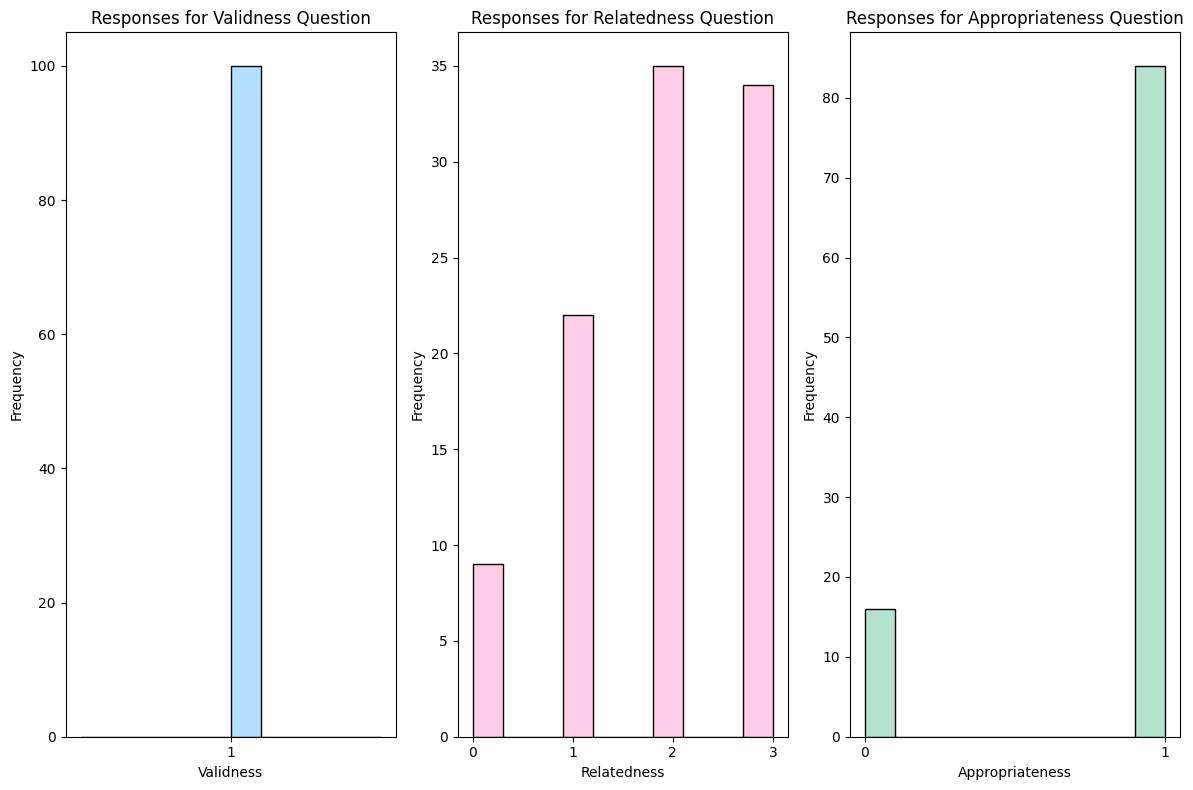

In [92]:
# Histogram of each questions
# Create separate histograms for each column
plt.figure(figsize=(12, 8))
colors = ['#B3E0FF', '#FFCCE5', '#B3E2CD']

plt.subplot(1, 3, 1)
plt.hist(df_converted['validness'], edgecolor='black', color=colors[0])
plt.title('Responses for Validness Question')
plt.xlabel('Validness')
plt.ylabel('Frequency')
plt.xticks(np.arange(int(df_converted['validness'].min()), int(df_converted['validness'].max()) + 1, 1))

plt.subplot(1, 3, 2)
plt.hist(df_converted['relatedness'], edgecolor='black', color=colors[1])
plt.title('Responses for Relatedness Question')
plt.xlabel('Relatedness')
plt.ylabel('Frequency')
plt.xticks(np.arange(int(df_converted['relatedness'].min()), int(df_converted['relatedness'].max()) + 1, 1))

plt.subplot(1, 3, 3)
plt.hist(df_converted['appropriateness'], edgecolor='black', color=colors[2])
plt.title('Responses for Appropriateness Question')
plt.xlabel('Appropriateness')
plt.ylabel('Frequency')
plt.xticks(np.arange(int(df_converted['appropriateness'].min()), int(df_converted['appropriateness'].max()) + 1, 1))

plt.tight_layout()
plt.show()

In [ ]:
# Mode 1 Release 2 Mean and Variance
# TODO

In [ ]:
# Mode 1 Cohen's Kappa
# TODO